In [1]:
from cv2 import resize
import numpy as np
import pandas as pd
import matplotlib
import os
from matplotlib import image, pyplot as plt

In [2]:
def get_image_data(h_types, window, h_type_image_count, dim, rand=0):
    np.random.seed(rand)
    data = []
    labels = []
    num_images_list = [h_type_image_count for _ in range(len(h_types))] if isinstance(h_type_image_count, int) else h_type_image_count
    assert(len(num_images_list) == len(h_types))
    
    for h_type, num_images in zip(h_types, num_images_list):
        print(f'Starting {h_type}.')
        file_dir = f'dcms/renders/{h_type}/{window}/'
        img_names = np.array(os.listdir(file_dir))
        np.random.shuffle(img_names)
        if (n := len(img_names)) < num_images:
            print(f'You asked for {num_images}, but can only find {n} for {h_type}. Returning {n} images.')
        else:
            img_names = img_names[:num_images]

        ACTUAL_NUM_IMAGES = len(img_names)

        pulled_data = np.zeros([ACTUAL_NUM_IMAGES, dim[0] * dim[1]])

        for i, img in enumerate(img_names):
            if (i % 1000) == 0:
                print(f'{h_type}: {i}/{pulled_data.shape[0]}')
            im = np.mean(matplotlib.image.imread(file_dir + img),axis=2)
            if ((s := im.shape) != (512,512)):
                print(f'{img} not of correct dimensions (512,512). It is instead {s}. Removing image.')
                ACTUAL_NUM_IMAGES -= 1
                continue
            pulled_data[i,:] = resize(im, dim).reshape(1, -1)
        
        data.append(pulled_data[:ACTUAL_NUM_IMAGES])
        labels.append(np.repeat(h_type, ACTUAL_NUM_IMAGES))
        print(f'Finished {h_type}.')
    
    return np.concatenate(data), np.concatenate(labels)

In [3]:
X, y = get_image_data(['epidural', 'normal', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural'], 'brain_window', 100, (64,64))

Starting epidural.
epidural: 0/100
Finished epidural.
Starting normal.
normal: 0/100
Finished normal.
Starting intraparenchymal.
intraparenchymal: 0/100
Finished intraparenchymal.
Starting intraventricular.
intraventricular: 0/100
Finished intraventricular.
Starting subarachnoid.
subarachnoid: 0/100
Finished subarachnoid.
Starting subdural.
subdural: 0/100
ID_a9ab8569f.jpg not of correct dimensions (512,512). It is instead (408, 374). Removing image.
Finished subdural.


In [4]:
print(X.shape)
print(y.shape)

(599, 4096)
(599,)


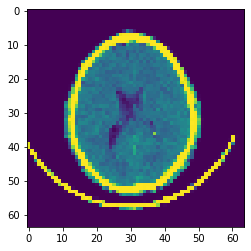

In [5]:
matplotlib.pyplot.imshow(X[2].reshape(64,64));

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D

In [7]:
hem_type_dict = {'epidural':0,
                 'intraparenchymal':1,
                 'intraventricular':2,
                 'normal':3,
                 'subarachnoid':4,
                 'subdural':5}
y_numerical = np.array([hem_type_dict.get(i) for i in y])

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y_numerical, test_size=0.2, random_state=0)
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X, y_numerical, test_size=0.2, random_state=0)
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(X, y_numerical, test_size=0.2, random_state=0)
X_train4, X_valid4, y_train4, y_valid4 = train_test_split(X, y_numerical, test_size=0.2, random_state=0)
print(y_train.shape, y_valid.shape)
print(X_train.shape, X_valid.shape)

(479,) (120,)
(479, 4096) (120, 4096)


<h3> NEURAL NETS! </h3>

In [9]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
NUM_LABELS = 6

# renormalize training data
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_train /= 255
X_valid /= 255


X_train = X_train.reshape(-1,64,64,1)
X_valid = X_valid.reshape(-1,64,64,1)

y_train = np_utils.to_categorical(y_train, NUM_LABELS)
y_valid = np_utils.to_categorical(y_valid, NUM_LABELS)

print(X_train.shape, X_valid.shape)

(479, 64, 64, 1) (120, 64, 64, 1)


In [11]:
# Creating our model
model = Sequential()

model.add(Conv2D(32, (7,7),
                 padding='valid',
                 input_shape=(64,64,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=NUM_LABELS, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0

In [12]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
epochs = 5

history = model.fit(X_train, 
                    y_train, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1,
                    validation_data=(X_valid, y_valid))

Epoch 1/5


2022-05-01 18:14:04.063389: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 1s 108ms/step - loss: 1.8339 - accuracy: 0.1608 - val_loss: 1.8014 - val_accuracy: 0.1583
Epoch 2/5
4/4 [==============================] - 0s 77ms/step - loss: 1.7832 - accuracy: 0.2338 - val_loss: 1.8063 - val_accuracy: 0.2000
Epoch 3/5
4/4 [==============================] - 0s 78ms/step - loss: 1.7502 - accuracy: 0.2568 - val_loss: 1.8376 - val_accuracy: 0.1333
Epoch 4/5
4/4 [==============================] - 0s 77ms/step - loss: 1.6978 - accuracy: 0.3152 - val_loss: 1.7968 - val_accuracy: 0.2083
Epoch 5/5
4/4 [==============================] - 0s 76ms/step - loss: 1.6864 - accuracy: 0.2797 - val_loss: 1.7563 - val_accuracy: 0.2750


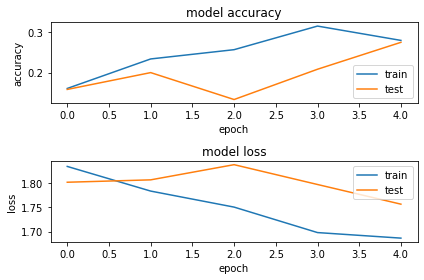

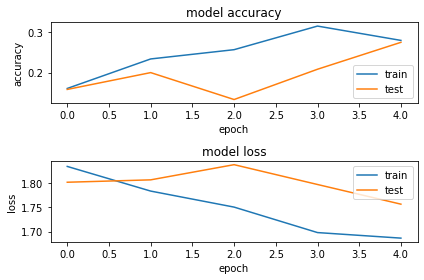

In [14]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig